<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">

# Profile extraction, LoD and data cleaning

<font size="3"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<b>This notebook covers the following concepts:</b>

- The ProfileSet class.
- Data extraction.
- Limit of Detections (LoDs).
</font>


</font>

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import pandas as pd
import rasterio as ras
from rasterio.plot import show

from sandpyper.sandpyper import ProfileSet
from sandpyper.common import get_sil_location, get_opt_k

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Introduction

The __ProfileSet__ class is an object that contains all the information necessary to carry a typical *sandpyper* analysis from start to end. Once instantiated, it will contains a number of global variables that store some fundamental monitoring charasteristics such as:

* paths to the data directories
* coordinate reference systems of each site
* location codes and search keywords
* some monitoring parameters such as alongshore transect spacing, acrosshore sampling step and cleaning steps used
* and of course, the elevation and colour profile data.

Moreover, a few key methods will:

1. extract data from the provided transects
2. cluster extracted points using unsupervised clustering algorithm KMeans
3. clean the dataset with user-provided watermasks, shoremasks and fine-tuning polygons.

Moreover, when the __ProfileSet__ class is instantiated, it prints out the number of DSMs and orthophotos found for each location in the provided folders and it also creates a dataframe storing filenames, CRSs, location codes and raw dates extracted from the filenames. This dataframe is useful as a sanity check to see if all the information are correct before proceeding with the actual profile extraction. It will be stored as the attribute *ProfileSet.check*.

Let's see here how it all works...

First, create the required monitoring global settings.

In [2]:
# the paths to the DSM, orthophotos and transect directories
dirNameDSM=r'C:\my_packages\sandpyper\tests\test_data\dsm_1m'
dirNameOrtho=r'C:\my_packages\sandpyper\tests\test_data\orthos_1m'
dirNameTrans=r'C:\my_packages\sandpyper\tests\test_data\transects'

# the location codes used for the monitored locations
loc_codes=["mar","leo"]


# the keyword search dictionary
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                   'mar': ['Marengo','marengo','mar'] }


# the EPSG codes of the coordinate reference systems for each location code (location) given in CRS string format
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

# the transect spacing of the transects
transects_spacing=20

Then, create an instance of the ProfileSet class. Let's set 'check' parameter to 'all' to create the check dataframe
and store it in the variable P.check.


In [3]:
P=ProfileSet(dirNameDSM=dirNameDSM,
            dirNameOrtho=dirNameOrtho,
            dirNameTrans=dirNameTrans,
            transects_spacing=transects_spacing,
            loc_codes=loc_codes,
            loc_search_dict=loc_search_dict,
            crs_dict_string=crs_dict_string,
            check="all")

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


dsm from leo = 6

ortho from leo = 6

dsm from mar = 9

ortho from mar = 9


NUMBER OF DATASETS TO PROCESS: 30


Check the infromation extracted from the formatted filenames.
All the CRSs in a line (survey) must match!

In [4]:
P.check

,raw_date,location,filename_trs_ortho,crs_transect_dsm,filename_raster_dsm,filename_raster_ortho,crs_raster_dsm,crs_raster_ortho
0,20180606,leo,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32755,32755
1,20180713,leo,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32755,32755
2,20180920,leo,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32755,32755
3,20190211,leo,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32755,32755
4,20190328,leo,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32755,32755
5,20190731,leo,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32755,32755
6,20180601,mar,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32754,32754
7,20180621,mar,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32754,32754
8,20180727,mar,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32754,32754
9,20180925,mar,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754,C:\my_packages\sandpyper\tests\test_data\dsm_1...,C:\my_packages\sandpyper\tests\test_data\ortho...,32754,32754


## Extraction of profiles from folder

After checking the check dataframe and all looks right, we are ready to actually extract the data from both DSMs and orhtophotos using the *.extract_profiles* method.
Importantly, we also extract the data for the Limit of Detections (LoD) computation, using some transects digitised over areas we expect __NOT TO BE CHANGING__ in elevation during the monitoring period, also known as calibration zones.

Thus, the most important parameters to set are:

1. __sampling step__: indicates the __cross-shore sampling distance (m)__ that we want to use along our transects. Beware, although you could use a very small sampling distance (UAV datasets tend to be between few to 10 cm pixel size), file dimension will increase significantly!.

2. __lod__: this can be the path to a directory containing the lod transects to use as lod, a number to use as lod for all surveys in all locations or None.

In [5]:
# path to the LoD transects

lod_mode=r"C:\my_packages\sandpyper\tests\test_data\lod_transects"

The parameter __mode__ is here set to 'all' as we want to extract pixel values from both the DSMs and orthophotos, while the parameter __tr_ids__ specifies the name of the field in the transect file is used to store the transect IDs.

In [6]:
# run extraction from DSMs and orthos with 1m sampling steps and add X and Y fields to output geodataframe.
# use LoDs profiles provided.

P.extract_profiles(mode='all',tr_ids='tr_id',sampling_step=1,add_xy=True,lod_mode=lod_mode)

Extracting elevation from DSMs . . .


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:32805
Time for processing=42.378671407699585 seconds
First 10 rows are printed below
Number of points outside the raster extents: 9066
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 250
The extraction assigns NaN.
Extracting rgb values from orthos . . .


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:32805
Time for processing=44.43967795372009 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27198
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.
Extracting LoD values


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:1395
Time for processing=5.22626805305481 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.


__Note about missing values (numpy.nan)__

>NaNs might come from two different cases:
>1. extraction of points generated on transects falling __outside__ of the underlying raster extent
>2. points sampled from transect __inside__ the raster extent but containing NoData cells.
>
>Conveniently, the extraction profile function makes sure that if points fall outside the raster extent (case 1), those elevations are assigned a default nan value, in the NumPy np.nan form.
>In case 2, however, the values extracted depends on the definition of NaNs of the source raster format. In case the rasters provided do not have an assigned nan value in their metadata, the paramter __default_nan_values__ can be used to specify one.

Done!

Now the profile attribute of the ProfileSet object we are working with (here, *P*) stores the geopandas.GeoDataFrame containing the extracted data.

In [7]:
P.profiles

,distance,z,coordinates,location,survey_date,raw_date,tr_id,point_id,x,y,band1,band2,band3
0,0.0,0.007440,POINT (731646.904 5705523.469),mar,2019-05-16,20190516,24,64121091m2580400ar00,731646.903760,5.705523e+06,114.0,139.0,128.0
1,1.0,0.008439,POINT (731646.078 5705524.033),mar,2019-05-16,20190516,24,64123091m2580600ar10,731646.078301,5.705524e+06,117.0,139.0,127.0
2,2.0,0.010800,POINT (731645.253 5705524.598),mar,2019-05-16,20190516,24,64129091m2530100ar20,731645.252842,5.705525e+06,122.0,140.0,127.0
3,3.0,0.011350,POINT (731644.427 5705525.162),mar,2019-05-16,20190516,24,64124091m2570800ar30,731644.427383,5.705525e+06,125.0,144.0,133.0
4,4.0,0.028030,POINT (731643.602 5705525.727),mar,2019-05-16,20190516,24,64120091m2520400ar40,731643.601924,5.705526e+06,126.0,145.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32800,44.0,NaN,POINT (300201.502 5772859.891),leo,2018-06-06,20180606,0,60101080l2624100eo40,300201.501848,5.772860e+06,NaN,NaN,NaN
32801,45.0,NaN,POINT (300202.298 5772860.496),leo,2018-06-06,20180606,0,60100080l2665200eo40,300202.298010,5.772860e+06,NaN,NaN,NaN
32802,46.0,NaN,POINT (300203.094 5772861.101),leo,2018-06-06,20180606,0,60100080l2606300eo40,300203.094172,5.772861e+06,NaN,NaN,NaN
32803,47.0,NaN,POINT (300203.890 5772861.706),leo,2018-06-06,20180606,0,60109080l2647400eo40,300203.890334,5.772862e+06,NaN,NaN,NaN


<IPython.core.display.Javascript object>


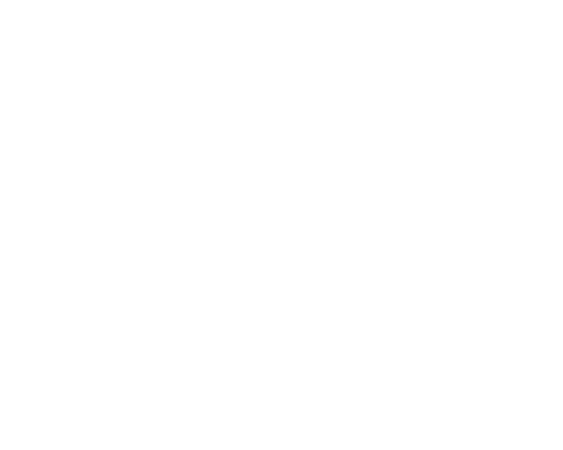

In [8]:
f,ax= plt.subplots(figsize=(10,8), squeeze=True)
ortho_path=r"C:\my_packages\sandpyper\tests\test_data\orthos_1m\leo_20180606_ortho_resampled_1m.tif"

with ras.open(ortho_path,'r') as ortho:

    show(ortho, ax=ax)


P.profiles.query("location=='leo' and raw_date==20180606").plot(ax=ax,column='z', cmap='RdBu_r');

As you can see, the profiles include points extracted over areas that are not beach sediment, such as water, swash (inaccurate modeled elevation), vegetation or anything else that can be found aôn or around a beach that is not sand.

Computing mutitemporal elevation changes from a dataset of this kind would lead in very erroneous computation as it would include all the aforementioned non-sand points. Therefore, we need to clip out the water from each dataset, retain only a small area of interest landward that the principal foredune (if any) and classify each extracted point as sand or no-sand.

Let's see how we can achieve this using sandpyper and Qgis.

## Unsupervised clustering and labelling
( for method information, please check the documentation, [here](https://npucino.github.io/sandpyper/) )

### The challenge
In order to help discriminate and deal with non-sand points in our dataset, we can use Machine Learning (ML) to classify which points are sand and which ones are not.

Currently, sandpyper only facilitates the use of KMeans unsupervised clustering algorithm to accomplish this task. KMeans assigns points sharing similarities in the attribute space to one of a predefined number of clusters and assign these clusters one label. After the clustering is done, we, the human operator, need to visually look at the clustering results in a GIS, overlay the points on the orthophoto, visualise their color-coded labels and 'attach a meaning' to those clusters, which can be quite difficult as ML sees quite differently from us.

Of course one could also be tempted to use supervised machine learning techniques, however, considering that the cameras mounted on UAVs are not calibrated and the RGB images are not corrected for illumination variations, the training process would require a very big training dataset which must capture as much as variance in the classes of interest as possible.
In this case, the unsupervised procedure facilitated by sandpyper could help in constructing an high quality training dataset.

### Iterative Silhouette analysis with inflexion search
One of the most important parameter we must set before running KMeans is how many clusters we want to partition our points in. Considering that the next step is our visual checking of each cluster, we should choose a number that is not too high, as it would require too much time to visually assign a class to each cluster, but neighter too low, as this would dramatically increase the likelyhood of finding mixed clusters containing both points that are sand and no-sand.

In order to let the data guide our choice of number of clusters to use, sandpyper implements an automated iterative Silhouette analysis with inflexion search algorithm.
This algorithms use Silhouette coefficients to compute the clustering performances and allows to return a sub-optimal number of clusters to use in each survey with KMeans which minimise the likelyhood of having mixed clusters while also retaining a low number of clusters.

Sandpyper implements this in 3 steps:

1. __get_sil_location__: iteratively perform KMeans clustering and Silhouette Analysis with increasing number of clusters (k, specified in the `ks` parameter) for every survey, using the feature set specified in the parameter `feature_set`
2. __get_opt_k__ : uses the dataframe with Average Silhouette scores with different k for all surveys created by __get_sil_location__ function to find a sub-optimal number of clusters for each survey
3. __kmeans_sa__ method: to run KMeans algorithm with the specified sub-optimal number of clusters (k)

In [9]:
# Run interatively KMeans + SA using the feature_set provided
#feel free to add 

feature_set=["band1","band2","band3","distance"]
sil_df=get_sil_location(P.profiles,
                        ks=(2,15), 
                        feature_set=feature_set,
                       random_state=10)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Working on : mar, 20190516.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.6219865168763407
For n_clusters = 3 The average silhouette_score is : 0.535782834177223
For n_clusters = 4 The average silhouette_score is : 0.5360693626824162
For n_clusters = 5 The average silhouette_score is : 0.4560535847617118
For n_clusters = 6 The average silhouette_score is : 0.45529082978244856
For n_clusters = 7 The average silhouette_score is : 0.44623104595368007
For n_clusters = 8 The average silhouette_score is : 0.4276467073078296
For n_clusters = 9 The average silhouette_score is : 0.39984472497160034
For n_clusters = 10 The average silhouette_score is : 0.3944833658664287
For n_clusters = 11 The average silhouette_score is : 0.39290037915600995
For n_clusters = 12 The average silhouette_score is : 0.3626866522843635
For n_clusters = 13 The average silhouette_score is : 0.3537214969510808
For n_clusters = 14 The average silhouette_score is : 0.360049558138258
Working on : mar, 20190313.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.557958595647791
For n_clusters = 3 The average silhouette_score is : 0.5140648301846097
For n_clusters = 4 The average silhouette_score is : 0.5018436513556769
For n_clusters = 5 The average silhouette_score is : 0.433979206893076
For n_clusters = 6 The average silhouette_score is : 0.417124057365699
For n_clusters = 7 The average silhouette_score is : 0.41877526043796687
For n_clusters = 8 The average silhouette_score is : 0.3813644990945346
For n_clusters = 9 The average silhouette_score is : 0.38298598316290156
For n_clusters = 10 The average silhouette_score is : 0.38780357139523025
For n_clusters = 11 The average silhouette_score is : 0.3705944933198418
For n_clusters = 12 The average silhouette_score is : 0.3651637741592011
For n_clusters = 13 The average silhouette_score is : 0.3626901435079943
For n_clusters = 14 The average silhouette_score is : 0.364312347054231
Working on : mar, 20190205.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5864811907668233
For n_clusters = 3 The average silhouette_score is : 0.5287826504696901
For n_clusters = 4 The average silhouette_score is : 0.5135421029464969
For n_clusters = 5 The average silhouette_score is : 0.4307716357147362
For n_clusters = 6 The average silhouette_score is : 0.4198951039452866
For n_clusters = 7 The average silhouette_score is : 0.4216561839748987
For n_clusters = 8 The average silhouette_score is : 0.4048963177852256
For n_clusters = 9 The average silhouette_score is : 0.40309220394346107
For n_clusters = 10 The average silhouette_score is : 0.3863324302013023
For n_clusters = 11 The average silhouette_score is : 0.3797930282754271
For n_clusters = 12 The average silhouette_score is : 0.38096229910474133
For n_clusters = 13 The average silhouette_score is : 0.38270148296414735
For n_clusters = 14 The average silhouette_score is : 0.38101196831610196
Working on : mar, 20181211.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5408421089322027
For n_clusters = 3 The average silhouette_score is : 0.5230591336669079
For n_clusters = 4 The average silhouette_score is : 0.5212604455141028
For n_clusters = 5 The average silhouette_score is : 0.4229400387683722
For n_clusters = 6 The average silhouette_score is : 0.45245862927127983
For n_clusters = 7 The average silhouette_score is : 0.4483238394769186
For n_clusters = 8 The average silhouette_score is : 0.4196417680949735
For n_clusters = 9 The average silhouette_score is : 0.40611511715414134
For n_clusters = 10 The average silhouette_score is : 0.38659542553842996
For n_clusters = 11 The average silhouette_score is : 0.3696055524901218
For n_clusters = 12 The average silhouette_score is : 0.37009962399500085
For n_clusters = 13 The average silhouette_score is : 0.35527656663572244
For n_clusters = 14 The average silhouette_score is : 0.3465435289160837
Working on : mar, 20181113.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5653353599190023
For n_clusters = 3 The average silhouette_score is : 0.48082172651613736
For n_clusters = 4 The average silhouette_score is : 0.4739355249881875
For n_clusters = 5 The average silhouette_score is : 0.44998542160594424
For n_clusters = 6 The average silhouette_score is : 0.46793686792032685
For n_clusters = 7 The average silhouette_score is : 0.45141377362406754
For n_clusters = 8 The average silhouette_score is : 0.4282875609756635
For n_clusters = 9 The average silhouette_score is : 0.41407851845524357
For n_clusters = 10 The average silhouette_score is : 0.40718423656045105
For n_clusters = 11 The average silhouette_score is : 0.3903647922431344
For n_clusters = 12 The average silhouette_score is : 0.3839833647433829
For n_clusters = 13 The average silhouette_score is : 0.38065272471925277
For n_clusters = 14 The average silhouette_score is : 0.3832072967705472
Working on : mar, 20180925.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5781993163219185
For n_clusters = 3 The average silhouette_score is : 0.5170856406873439
For n_clusters = 4 The average silhouette_score is : 0.48466929384434043
For n_clusters = 5 The average silhouette_score is : 0.4373504056027659
For n_clusters = 6 The average silhouette_score is : 0.39375906953445383
For n_clusters = 7 The average silhouette_score is : 0.38864190848914665
For n_clusters = 8 The average silhouette_score is : 0.4035256487664215
For n_clusters = 9 The average silhouette_score is : 0.3798356038299367
For n_clusters = 10 The average silhouette_score is : 0.37962054426443537
For n_clusters = 11 The average silhouette_score is : 0.3644375001522226
For n_clusters = 12 The average silhouette_score is : 0.3558265298038209
For n_clusters = 13 The average silhouette_score is : 0.34528697717595713
For n_clusters = 14 The average silhouette_score is : 0.35004508855406896
Working on : mar, 20180727.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5803251747670938
For n_clusters = 3 The average silhouette_score is : 0.48850610227959923
For n_clusters = 4 The average silhouette_score is : 0.4772654299979584
For n_clusters = 5 The average silhouette_score is : 0.4135001777584117
For n_clusters = 6 The average silhouette_score is : 0.38283314263428714
For n_clusters = 7 The average silhouette_score is : 0.3755827513627956
For n_clusters = 8 The average silhouette_score is : 0.3486272625814806
For n_clusters = 9 The average silhouette_score is : 0.3367906257895182
For n_clusters = 10 The average silhouette_score is : 0.3273888373123684
For n_clusters = 11 The average silhouette_score is : 0.30071888963336296
For n_clusters = 12 The average silhouette_score is : 0.3219840164575009
For n_clusters = 13 The average silhouette_score is : 0.3222155159146202
For n_clusters = 14 The average silhouette_score is : 0.307958370621084
Working on : mar, 20180621.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5439589764752933
For n_clusters = 3 The average silhouette_score is : 0.4387708619085413
For n_clusters = 4 The average silhouette_score is : 0.4501935908699898
For n_clusters = 5 The average silhouette_score is : 0.3963414382040067
For n_clusters = 6 The average silhouette_score is : 0.41807731086369254
For n_clusters = 7 The average silhouette_score is : 0.3871968978951222
For n_clusters = 8 The average silhouette_score is : 0.37393061831106983
For n_clusters = 9 The average silhouette_score is : 0.3443142601476958
For n_clusters = 10 The average silhouette_score is : 0.3585650473719073
For n_clusters = 11 The average silhouette_score is : 0.35570748604269775
For n_clusters = 12 The average silhouette_score is : 0.3575633171508779
For n_clusters = 13 The average silhouette_score is : 0.37087632012718563
For n_clusters = 14 The average silhouette_score is : 0.3795271430686032
Working on : mar, 20180601.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.48270415311106846
For n_clusters = 3 The average silhouette_score is : 0.3772084152830261
For n_clusters = 4 The average silhouette_score is : 0.38234628609235827
For n_clusters = 5 The average silhouette_score is : 0.38128225187445997
For n_clusters = 6 The average silhouette_score is : 0.36428432858349613
For n_clusters = 7 The average silhouette_score is : 0.36240034713437685
For n_clusters = 8 The average silhouette_score is : 0.3701424025696913
For n_clusters = 9 The average silhouette_score is : 0.37175207788683484
For n_clusters = 10 The average silhouette_score is : 0.37676977350569846
For n_clusters = 11 The average silhouette_score is : 0.37582649170780724
For n_clusters = 12 The average silhouette_score is : 0.3619596723553155
For n_clusters = 13 The average silhouette_score is : 0.360705274650356
For n_clusters = 14 The average silhouette_score is : 0.3549151019500089


  0%|          | 0/6 [00:00<?, ?it/s]

Working on : leo, 20190731.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3899198233106219
For n_clusters = 3 The average silhouette_score is : 0.5071438060156596
For n_clusters = 4 The average silhouette_score is : 0.47005119135652856
For n_clusters = 5 The average silhouette_score is : 0.4481907289981238
For n_clusters = 6 The average silhouette_score is : 0.42502882450684076
For n_clusters = 7 The average silhouette_score is : 0.4011433092740131
For n_clusters = 8 The average silhouette_score is : 0.38998808479733066
For n_clusters = 9 The average silhouette_score is : 0.38559916622535073
For n_clusters = 10 The average silhouette_score is : 0.38736594985557654
For n_clusters = 11 The average silhouette_score is : 0.3788805356672864
For n_clusters = 12 The average silhouette_score is : 0.37132878563783606
For n_clusters = 13 The average silhouette_score is : 0.3728000521740459
For n_clusters = 14 The average silhouette_score is : 0.37291633707910765
Working on : leo, 20190328.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3988524141238273
For n_clusters = 3 The average silhouette_score is : 0.4304685615621422
For n_clusters = 4 The average silhouette_score is : 0.431227035737659
For n_clusters = 5 The average silhouette_score is : 0.4509750902886234
For n_clusters = 6 The average silhouette_score is : 0.42012497505273527
For n_clusters = 7 The average silhouette_score is : 0.4094032569946379
For n_clusters = 8 The average silhouette_score is : 0.42729379253757904
For n_clusters = 9 The average silhouette_score is : 0.41690585873078206
For n_clusters = 10 The average silhouette_score is : 0.4226788217215935
For n_clusters = 11 The average silhouette_score is : 0.41351261817558693
For n_clusters = 12 The average silhouette_score is : 0.4087415403998031
For n_clusters = 13 The average silhouette_score is : 0.38543846003780563
For n_clusters = 14 The average silhouette_score is : 0.3783301865582882
Working on : leo, 20190211.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3811803323084047
For n_clusters = 3 The average silhouette_score is : 0.48727929000883047
For n_clusters = 4 The average silhouette_score is : 0.44313687819005354
For n_clusters = 5 The average silhouette_score is : 0.45097582364485633
For n_clusters = 6 The average silhouette_score is : 0.4320727369612193
For n_clusters = 7 The average silhouette_score is : 0.4166514336483687
For n_clusters = 8 The average silhouette_score is : 0.39445247084076124
For n_clusters = 9 The average silhouette_score is : 0.3718047003108205
For n_clusters = 10 The average silhouette_score is : 0.36905766574894283
For n_clusters = 11 The average silhouette_score is : 0.3723670925736636
For n_clusters = 12 The average silhouette_score is : 0.35518841237259613
For n_clusters = 13 The average silhouette_score is : 0.35415290301652735
For n_clusters = 14 The average silhouette_score is : 0.33383141602938693
Working on : leo, 20180920.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.4039166622963731
For n_clusters = 3 The average silhouette_score is : 0.4367493135688848
For n_clusters = 4 The average silhouette_score is : 0.42434419318841404
For n_clusters = 5 The average silhouette_score is : 0.4443994359362926
For n_clusters = 6 The average silhouette_score is : 0.4175864662989779
For n_clusters = 7 The average silhouette_score is : 0.38860870508958795
For n_clusters = 8 The average silhouette_score is : 0.38880003508342514
For n_clusters = 9 The average silhouette_score is : 0.3830287983992327
For n_clusters = 10 The average silhouette_score is : 0.37353163965128733
For n_clusters = 11 The average silhouette_score is : 0.36620965721819637
For n_clusters = 12 The average silhouette_score is : 0.3536600836899299
For n_clusters = 13 The average silhouette_score is : 0.3585083805642395
For n_clusters = 14 The average silhouette_score is : 0.35672016047028215
Working on : leo, 20180713.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.49629965872244686
For n_clusters = 3 The average silhouette_score is : 0.5092406492417487
For n_clusters = 4 The average silhouette_score is : 0.46159478658042724
For n_clusters = 5 The average silhouette_score is : 0.4488595142176017
For n_clusters = 6 The average silhouette_score is : 0.4183623304561938
For n_clusters = 7 The average silhouette_score is : 0.39004221840210485
For n_clusters = 8 The average silhouette_score is : 0.3842278112748862
For n_clusters = 9 The average silhouette_score is : 0.36304035595403583
For n_clusters = 10 The average silhouette_score is : 0.3463760386521644
For n_clusters = 11 The average silhouette_score is : 0.34841430296451464
For n_clusters = 12 The average silhouette_score is : 0.3460546307634773
For n_clusters = 13 The average silhouette_score is : 0.34457917043266856
For n_clusters = 14 The average silhouette_score is : 0.3318667826222712
Working on : leo, 20180606.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.4012079287817844
For n_clusters = 3 The average silhouette_score is : 0.4563078554750914
For n_clusters = 4 The average silhouette_score is : 0.40640166442880776
For n_clusters = 5 The average silhouette_score is : 0.4001757072050638
For n_clusters = 6 The average silhouette_score is : 0.3890044660503746
For n_clusters = 7 The average silhouette_score is : 0.3716889344520391
For n_clusters = 8 The average silhouette_score is : 0.36600629265911533
For n_clusters = 9 The average silhouette_score is : 0.3503569988098764
For n_clusters = 10 The average silhouette_score is : 0.34651080656561367
For n_clusters = 11 The average silhouette_score is : 0.34322073624826754
For n_clusters = 12 The average silhouette_score is : 0.3439561998875081
For n_clusters = 13 The average silhouette_score is : 0.347961415981389
For n_clusters = 14 The average silhouette_score is : 0.33782737875946023


Find sub-optimal k by searching inflexion points where an additional cluster do not considerably degrade the overall clustering performance.

In [10]:
opt_k=get_opt_k(sil_df, sigma=0 )
opt_k

{'leo_20180606': 11,
 'leo_20180713': 10,
 'leo_20180920': 4,
 'leo_20190211': 4,
 'leo_20190328': 7,
 'leo_20190731': 9,
 'mar_20180601': 3,
 'mar_20180621': 3,
 'mar_20180727': 11,
 'mar_20180925': 7,
 'mar_20181113': 5,
 'mar_20181211': 5,
 'mar_20190205': 6,
 'mar_20190313': 6,
 'mar_20190516': 3}

If we are not satisfied with the sub-optimal k returned by the algorithm, we can manually specify each survey k
by defining a dictionary.

In [ ]:
# Based on our observations on a dataset comprising 87 surveys, 10 clusters (k=10) is generally a good tradeoff.

opt_k={'leo_20180606': 10,
 'leo_20180713': 10,
 'leo_20180920': 10,
 'leo_20190211': 10,
 'leo_20190328': 10,
 'leo_20190731': 10,
 'mar_20180601': 10,
 'mar_20180621': 10,
 'mar_20180727': 10,
 'mar_20180925': 10,
 'mar_20181113': 10,
 'mar_20181211': 10,
 'mar_20190205': 10,
 'mar_20190313': 10,
 'mar_20190516': 10}

or, update one value only. For instance, in mar_2019-05-16 dataset, it is unlikely that 3 clusters are enough.<br>
So, we replace only that value with 10.

In [ ]:
#opt_k['mar_2019-05-16']=10

In [11]:
feature_set=["band1","band2","band3","distance"]

P.kmeans_sa(opt_k,feature_set)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

DONE! Now, the profile dataframe attribute has an additional column named __label_k__, which is the result of the survey specific KMeans algorithm.

In [12]:
P.profiles.head()

,distance,z,coordinates,location,survey_date,raw_date,tr_id,point_id,x,y,band1,band2,band3,label_k
0,0.0,1.130296,POINT (299873.218 5773731.860),leo,2018-06-06,20180606,47,67144080l2610600eo00,299873.217965,5.773732e+06,133.0,143.0,104.0,8
1,1.0,1.085163,POINT (299874.212 5773731.971),leo,2018-06-06,20180606,47,67148080l2690700eo10,299874.211725,5.773732e+06,109.0,107.0,106.0,8
2,2.0,1.033864,POINT (299875.205 5773732.083),leo,2018-06-06,20180606,47,67143080l2670800eo20,299875.205484,5.773732e+06,98.0,94.0,105.0,8
3,3.0,1.025817,POINT (299876.199 5773732.194),leo,2018-06-06,20180606,47,67148080l2650800eo30,299876.199244,5.773732e+06,99.0,97.0,108.0,8
4,4.0,1.041824,POINT (299877.193 5773732.306),leo,2018-06-06,20180606,47,67143080l2630900eo40,299877.193003,5.773732e+06,103.0,109.0,127.0,8


Now that we have labelled the data points, we need to:
1. export the dataframe as csv
2. import it into your favourite GIS and use the __coordinates__ column as geometry
3. using the filtering options, visualise only one survey at a time and assign one color per unique label_k value
4. overlay these points on the orthophoto of the survey they were extracted from
5. take notes of which label_k number is what class (sand, no_sand at least)
6. create the label corrections file (polygons), following the specifications descirbed in the previous notebook.

## Sand labeling and cleaning

Here below I provided the classes dictionaries of the demo data clustering results.

Each class has its own dictionary. The keys store the survey identifier tag ('LocCode_yyyymmdd') and the values are lists of label_k associated with the dictionary class.

For instance in this example:

```python
sand_dict = {'leo_20180606':[5],
            'leo_20180713':[1,3,4],
            'mar_20180920':[]}
            
water_dict = {'leo_20180606':[4],
            'leo_20180713':[2,6],
            'mar_20180920':[1,2,3,4]}
```

In the St. Leonards survey of the 13th July 2018, the label_k 1,3 and 4 are sand, while the label_k 2 and 6 are water.
In Marengo, the 20th September 2018, no label_k represents sand while 1,2,3 and 4 are water.

Here below are reported the label dictionaries of the demo data.

In [13]:
water_dict={'leo_20180606':[0,9,10],
'leo_20180713':[0,3,4,7],
'leo_20180920':[0,2,6,7],
'leo_20190211':[0,2,5],
'leo_20190328':[2,4,5],
'leo_20190731':[0,2,8,6],
'mar_20180601':[1,6],
'mar_20180621':[4,6],
'mar_20180727':[0,5,9,10],
'mar_20180925':[6],
'mar_20181113':[1],
'mar_20181211':[4],
'mar_20190205':[],
'mar_20190313':[],
'mar_20190516':[4,7]}

no_sand_dict={'leo_20180606':[5],
'leo_20180713':[],
'leo_20180920':[],
'leo_20190211':[1],
'leo_20190328':[],
'leo_20190731':[1],
'mar_20180601':[4,5],
'mar_20180621':[3,5],
'mar_20180727':[4,7],
'mar_20180925':[5],
'mar_20181113':[0],
'mar_20181211':[0],
'mar_20190205':[0,5],
'mar_20190313':[4],
'mar_20190516':[2,5]}

veg_dict={'leo_20180606':[1,3,7,8],
'leo_20180713':[1,5,9],
'leo_20180920':[1,4,5],
'leo_20190211':[4],
'leo_20190328':[0,1,6],
'leo_20190731':[3,7],
'mar_20180601':[0,7],
'mar_20180621':[1,7],
'mar_20180727':[1,3],
'mar_20180925':[1,3],
'mar_20181113':[3],
'mar_20181211':[2],
'mar_20190205':[3],
'mar_20190313':[1,5],
'mar_20190516':[0]}

sand_dict={'leo_20180606':[2,4,6],
'leo_20180713':[2,6,8],
'leo_20180920':[3],
'leo_20190211':[3],
'leo_20190328':[3],
'leo_20190731':[4,5],
'mar_20180601':[2,3],
'mar_20180621':[0,2],
'mar_20180727':[2,6,8],
'mar_20180925':[0,4,2],
'mar_20181113':[2,4],
'mar_20181211':[3,1],
'mar_20190205':[1,2,4],
'mar_20190313':[0,2,3],
'mar_20190516':[1,3,6]}

Now that we have each class dictionary, let's put all of those in another dictionary in order to specify the name of the class.
Like this:

In [14]:
l_dicts={'no_sand': no_sand_dict,
         'sand': sand_dict,
        'water': water_dict,
        'veg':veg_dict}

Now, let's provide the paths to the geopackages (preferred, but also shapefiles are accepted) containing the label corrections, the watermasks and the shoremasks.

In [15]:
label_corrections_path=r"C:\my_packages\sandpyper\tests\test_data\clean\label_corrections.gpkg"
watermasks_path=r"C:\my_packages\sandpyper\tests\test_data\clean\watermasks.gpkg"
shoremasks_path=r"C:\my_packages\sandpyper\tests\test_data\clean\shoremasks.gpkg"

All set!

Now we are ready to use the __.cleanit method__ to:

1. classify each point using the dictionaries provided
2. fine-tuning the label_k using the label correction polygons provided
3. eliminate water/swash points using the watermasks provided
4. clip to the shore area using the shoremasks provided


In [16]:
P.cleanit(l_dicts=l_dicts,
          watermasks_path=watermasks_path,
          shoremasks_path=shoremasks_path,
          label_corrections_path=label_corrections_path)

Reclassifying dataset with the provided dictionaries.
Label corrections provided in CRS: epsg:32754
Fine tuning in leo.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/6 [00:00<?, ?it/s]

Fine-tuning label_k 3 to no_sand in leo-20180606, found 127 pts.
Fine-tuning label_k 8 to no_sand in leo-20180606, found 73 pts.
Fine-tuning label_k 5 to no_sand in leo-20180713, found 56 pts.
Fine-tuning label_k 6 to no_sand in leo-20180713, found 7 pts.
Fine-tuning label_k 1 to no_sand in leo-20180920, found 89 pts.
Fine-tuning label_k 2 to sand in leo-20180920, found 9 pts.
Fine-tuning label_k 2 to veg in leo-20180920, found 31 pts.
Fine-tuning label_k 6 to sand in leo-20180920, found 17 pts.
Fine-tuning label_k 2 to veg in leo-20190211, found 2 pts.
Fine-tuning label_k 6 to veg in leo-20190211, found 29 pts.
Fine-tuning label_k 6 to no_sand in leo-20190211, found 2 pts.
Fine-tuning label_k 6 to veg in leo-20190211, found 6 pts.
Fine-tuning label_k 6 to sand in leo-20190211, found 28 pts.
Fine-tuning label_k 7 to no_sand in leo-20190211, found 41 pts.
Fine-tuning label_k 0 to sand in leo-20190328, found 6 pts.
Fine-tuning label_k 0 to no_sand in leo-20190328, found 52 pts.
Fine-tuni

  0%|          | 0/6 [00:00<?, ?it/s]

Fine-tuning label_k 3 to water in mar-20180601, found 163 pts.
Fine-tuning label_k 7 to no_sand in mar-20180601, found 15 pts.
Fine-tuning label_k 7 to sand in mar-20180601, found 53 pts.
Fine-tuning label_k 1 to sand in mar-20180621, found 48 pts.
Fine-tuning label_k 3 to sand in mar-20180621, found 42 pts.
Fine-tuning label_k 2 to water in mar-20180727, found 98 pts.
Fine-tuning label_k 4 to sand in mar-20180727, found 29 pts.
Fine-tuning label_k 2 to no_sand in mar-20181211, found 45 pts.
Fine-tuning label_k 1 to water in mar-20181211, found 149 pts.
Fine-tuning label_k 2 to water in mar-20190205, found 304 pts.
Fine-tuning label_k 3 to no_sand in mar-20190205, found 23 pts.
Fine-tuning label_k 2 to water in mar-20190313, found 100 pts.
Fine-tuning label_k 5 to no_sand in mar-20190313, found 77 pts.
watermask  provided in CRS: epsg:32754
Applying watermasks cleaning.
Watermasking in mar.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/9 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 750 pts overlapping provided watermasks.
Setting to water 532 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be m

Setting to water 710 pts overlapping provided watermasks.
Setting to water 532 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 599 pts overlapping provided watermasks.
Setting to water 557 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 339 pts overlapping provided watermasks.
Setting to water 133 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 441 pts overlapping provided watermasks.
Watermasking in leo.


  0%|          | 0/6 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 652 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 555 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\s

Setting to water 638 pts overlapping provided watermasks.
Setting to water 627 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 583 pts overlapping provided watermasks.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Setting to water 643 pts overlapping provided watermasks.
shoremask  provided in CRS: epsg:32754
Applying shoremasks cleaning.
Shoremasking in mar.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".jo

Removing 3621 pts falling outside provided shore polygones.
Shoremasking in leo.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Removing 2358 pts falling outside provided shore polygones.
['polygon finetuning', 'watermasking', 'shoremasking'] completed.


DONE!

Now we have a cleaned and tidy classified dataset of elevation profiles, ready to be analysed to extract sediment specific altimetric, volumetric and behavioural dynamics information.

A new attribute has been stored, *ProfileSet.cleaning_steps*, which is a list of the cleaning steps applied to the current profiles.

In [17]:
P.cleaning_steps

['polygon finetuning', 'watermasking', 'shoremasking']

## Save it

To save the objects, just call the method *ProfileSet.save* with only two arguments:
1. the path to the folder where to save the data.
2. the name of the file you want to create.

In [18]:
dir_out=r'C:\my_packages\sandpyper\tests\test_data'

name="test"
P.save(name,dir_out)
P

ProfileSet object saved in C:\my_packages\sandpyper\tests\test_data\test.p .


## Conclusion

In this notebook we extracted the elevation and colour information from all our rasters and used it with an iterative Silhouette analysis and KMeans algorithm to unsupervisingly partition the data into clusters of similar points. Then, we assigned meaning of these labels using an external GIS and cleaned and clipped the data into our final slassified dataset. In the next notebook we will finally obtain multi-scale information about sediment dynamics in each site/transect.

___